In this notebook we:
- simulate some simple GeoRDD data with a constant treatment effect
- fit our Gaussian process GeoRDD to the simulated data
- show the estimated treatment effect along the border
- extract the local average treatment effect (LATE), showing we recover 
a reasonable estimate of the true treatment effect
- perform a significance test (obtain a $p$-value)

In [1]:
using DataFrames
using StatsModels
using LibGEOS
using GaussianProcesses
using Distributions
using Random
using Optim
using Printf
using LinearAlgebra

In [2]:
import PyPlot; 
plt=PyPlot;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/imolk/Library/Julia/alternative_depots/geordd/packages/PyPlot/4wzW1/src/init.jl:192


In [3]:
using Revise
using GeoRDD

┌ Info: Precompiling GeoRDD [5291867c-414d-5759-bfde-02a2d8b8319a]
└ @ Base loading.jl:1273


In [4]:
Random.seed!(1) # for replicability
n = 300
X = rand(2, n)
f_X = sin.(X[1,:] * 2.0) .+ 3.0 .* X[2,:].^2.0
m = -0.8 # mean offset
τ = 0.3 # constant treatment effect
treatment_radius = 0.8
covarA = randn(n)
covarB = randn(n)
categ = rand(["A", "B", "C"], n) # random cateogry
treat = sqrt.(X[1,:].^2 + X[2,:].^2) .< treatment_radius

# outcome is: smooth surface + noise + treatment effect
Y = m .+                 # mean offset
    f_X .+               # smooth surface
    0.3*randn(n) .+      # noise
    τ .* treat .+        # treatment effect
    covarA .* 0.1 .+     # effect of real-valued covariate
    (categ.=="B") .* 0.2 # raise category B a little bit
;

In [5]:
border_X1 = treatment_radius .* cos.(range(0,stop=π/2,length=1000))
border_X2 = treatment_radius .* sin.(range(0,stop=π/2,length=1000))
border_geo = LibGEOS.LineString([[border_X1[i], border_X2[i]] for i in 1:n])
;

In [6]:
geordd_df = DataFrame(
    X1 = X[1, :],
    X2 = X[2, :],
    outcome = Y,
    region = treat, # treatment indicator
    covarA = covarA,
    covarB = covarB,
    categ = categ
    )
categorical!(geordd_df, :categ)
categorical!(geordd_df, :region)
fmla = @formula(outcome ~ GP(X1, X2) | region + covarA + covarB + categ)
geordd = GeoRDD.regions_from_dataframe(fmla, geordd_df)
;

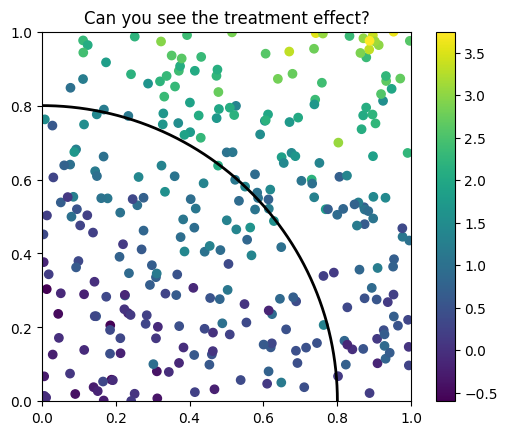

In [7]:
# plot the data and the border
plt.plot(border_X1, border_X2, color="black", linewidth=2)
plt.scatter(geordd_df.X1, geordd_df.X2, c=Y)
ax = plt.gca()
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_aspect("equal")
plt.colorbar()
plt.title("Can you see the treatment effect?")
;

In [8]:
# choose a Gaussian process kernel from the GaussianProcesses.jl package
k_se = SEIso(log(0.5), log(1.0)) # Squared Exponential spatial kernel
k_m = Const(log(20.0))           # constant kernel for the mean parameters
βkern = LinIso(log(1.0))         # linear kernel for the other covariates
logNoise = 1.0
# create the Gaussian process object from the regional data:
mgpcv = GeoRDD.MultiGPCovars(geordd, k_se+k_m, βkern, logNoise)
;

In [9]:
# optimize the hyperparameters
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        kern=true,
        domean=false,
        beta=true,
        options=Optim.Options(
            show_trace=false,
            iterations=1000,
            x_tol=1e-8,
            f_tol=1e-10),
    )
opt_output

  4.494917 seconds (9.80 M allocations: 552.091 MiB, 9.18% gc time)


 * Status: success

 * Candidate solution
    Minimizer: [-1.20e+00, -5.16e-03, 7.92e-01,  ...]
    Minimum:   1.231640e+02

 * Found with
    Algorithm:     Conjugate Gradient
    Initial Point: [1.00e+00, -6.93e-01, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.82e-05 ≰ 1.0e-08
    |x - x'|/|x'|          = 1.48e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.01e-09 ≰ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 1.63e-11 ≰ 0.0e+00
    |g(x)|                 = 5.08e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    74
    f(x) calls:    167
    ∇f(x) calls:   99


In [10]:
# fitted hyperparameters
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
kernspace = mgpcv.kernel.kleft
βkernel = mgpcv.βkern
@printf("σ_f: %.4f\n", √(kernspace.σ2))
@printf("ℓ: %.4f\n",   √(kernspace.ℓ2))
@printf("σ_β: %.4f\n", 1/√βkernel.ℓ2)


σ_y: 0.3008
σ_f: 2.2089
ℓ: 0.9949
σ_β: 0.0981


In [11]:
# extract posterior mean of linear regression coefficients
βhat = GeoRDD.postmean_β(mgpcv)
# extract residuals
residuals_rd = copy(geordd)
residuals_rd[true]  = GeoRDD.residuals_data(geordd[true],  βhat) # treatment region
residuals_rd[false] = GeoRDD.residuals_data(geordd[false], βhat) # control region
# Gaussian processes fitted to residuals:
resid_GP_dict = GeoRDD.GPRealisations(residuals_rd, mgpcv.kernel, mgpcv.logNoise)
;

In [12]:
# obtain posterior treatment effect along border
T,C = true, false
sentinels = GeoRDD.sentinels(border_geo, 100)
μpost, Σpost = GeoRDD.cliff_face(resid_GP_dict[T], 
                                 resid_GP_dict[C],
                                 sentinels)
;

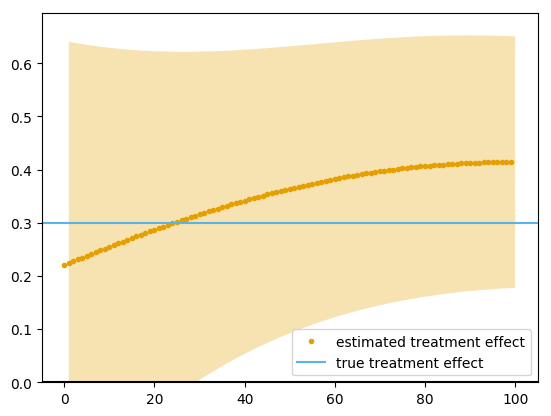

In [13]:
# plot cliff-face
let
    μ = μpost
    Σ = Σpost
    color = "#E69F00"
    plt.plot(μ, color=color, ".", label="estimated treatment effect")
    posterior_sd = sqrt.(diag(Σ))
    plt.fill_between(1:length(μ), μ.-2*posterior_sd, μ.+2*posterior_sd, 
        color=color, 
        alpha=0.3,
        linewidth=0,
        )
    plt.ylim(0)
    plt.axhline(0.0, color="black")
    plt.axhline(τ, color="#56B4E9", label="true treatment effect")
    plt.legend(loc="lower right")
end
;

In [14]:
# average treatment effect

println("inverse-variance weighted LATE")
println("==============================")
τ_inv=GeoRDD.inverse_variance(μpost, Σpost)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_inv), std(τ_inv))
@printf("P(τ<0|Y) = %.3f%%\n", cdf(τ_inv, 0.0)*100)

println("")

println("projected finite-population LATE")
println("================================")
kernspace = mgpcv.kernel.kleft
ℓ = sqrt(kernspace.ℓ2)
maxdist = 2ℓ
τ_proj = GeoRDD.proj_estimator(resid_GP_dict[T], 
                               resid_GP_dict[C], 
                               border_geo,
                               2ℓ)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_proj), std(τ_proj))
@printf("P(τ<0|Y) = %.3f%%", cdf(τ_proj, 0.0)*100)

inverse-variance weighted LATE
τ|Y ∼ Normal(μ=0.320, σ=0.092)
P(τ<0|Y) = 0.025%

projected finite-population LATE
τ|Y ∼ Normal(μ=0.398, σ=0.116)
P(τ<0|Y) = 0.031%

Both of these estimates are reasonable (the true treatment effect is τ=0.3).

In [15]:
# significance test
pval_invvar_calib = GeoRDD.pval_invvar_calib(
    resid_GP_dict[T],
    resid_GP_dict[C],
    sentinels
)

DomainError: DomainError with -153.10617351531982:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).